In [2]:
import pandas as pd

# CSV 파일 읽기
df_solar = pd.read_csv('df_merged_solar_final.csv')

In [4]:
import pandas as pd

# CSV 파일 읽기
df_solar = pd.read_csv('df_merged_solar_final.csv')

# ✅ '삼랑진태양광' 행 추출
df_sam = df_solar[df_solar['발전구분'] == '(군산)삼랑진태양광'].copy()

# ✅ 중복된 행 여부 확인 (일자+시간 기준)
dupe_mask = df_sam.duplicated(subset=['일자', '시간'], keep=False)

# ✅ 중복된 행들만 추출 (짝수 인덱스는 2MW, 홀수 인덱스는 1MW로)
df_dupe = df_sam[dupe_mask].copy()
df_dupe_2mw = df_dupe.iloc[::2].copy()
df_dupe_1mw = df_dupe.iloc[1::2].copy()

# ✅ 각각 발전구분명과 설비용량 변경
df_dupe_2mw['발전구분'] = '(군산)삼랑진태양광1'
df_dupe_2mw['설비용량(MW)'] = 2

df_dupe_1mw['발전구분'] = '(군산)삼랑진태양광2'
df_dupe_1mw['설비용량(MW)'] = 1

# ✅ 중복 데이터 제외한 원본 + 새로운 데이터 합치기
df_nondupe = df_solar[~((df_solar['발전구분'] == '(군산)삼랑진태양광') & dupe_mask)]
df_updated = pd.concat([df_nondupe, df_dupe_2mw, df_dupe_1mw], ignore_index=True)



In [5]:
def summarize_unique_values_full(df, threshold=50):
    print("✅ 컬럼별 유니크 값 및 개수 요약\n")
    
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        nunique = len(unique_vals)
        
        print(f"\n🔹 {col} ({df[col].dtype}) → 고유값 {nunique}개")

        if nunique > threshold:
            print("   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)\n")
        else:
            value_counts = df[col].value_counts(dropna=True)
            for val, count in value_counts.items():
                print(f"   • {val} : {count}개")

# 실행
summarize_unique_values_full(df_updated)


✅ 컬럼별 유니크 값 및 개수 요약


🔹 일자 (object) → 고유값 2556개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 발전구분 (object) → 고유값 6개
   • 영암에프원태양광b : 56934개
   • 안산연성정수장태양광 : 56886개
   • 세종시폐기물매립장태양광 : 56814개
   • (군산)삼랑진태양광1 : 8760개
   • (군산)삼랑진태양광2 : 8760개
   • 태안#9,10 수상태양광 : 8736개

🔹 설비용량(MW) (float64) → 고유값 6개
   • 13.296 : 56934개
   • 1.49 : 56886개
   • 1.628 : 56814개
   • 2.0 : 8760개
   • 1.0 : 8760개
   • 1.836 : 8736개

🔹 시간 (int64) → 고유값 24개
   • 24 : 8221개
   • 2 : 8203개
   • 23 : 8203개
   • 22 : 8203개
   • 21 : 8203개
   • 20 : 8203개
   • 19 : 8203개
   • 18 : 8203개
   • 17 : 8203개
   • 16 : 8203개
   • 15 : 8203개
   • 14 : 8203개
   • 1 : 8203개
   • 12 : 8203개
   • 11 : 8203개
   • 10 : 8203개
   • 9 : 8203개
   • 8 : 8203개
   • 7 : 8203개
   • 6 : 8203개
   • 5 : 8203개
   • 4 : 8203개
   • 3 : 8203개
   • 13 : 8203개

🔹 발전량(kWh) (float64) → 고유값 16997개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 연식(년) (float64) → 고유값 81개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 지점명 (object) → 고유값 5개
   • 목포 : 56934개
   • 수원 : 56886개
   • 청주 : 5

In [6]:
import pandas as pd



# 발전구분별 설비용량 확인
plant_capacity = df_updated.groupby('발전구분')['설비용량(MW)'].unique().reset_index()

# 보기 좋게 정리
plant_capacity['설비용량(MW)'] = plant_capacity['설비용량(MW)'].apply(lambda x: x[0] if len(x) == 1 else x)

print("발전구분별 설비용량:")
print(plant_capacity)


발전구분별 설비용량:
            발전구분  설비용량(MW)
0    (군산)삼랑진태양광1     2.000
1    (군산)삼랑진태양광2     1.000
2   세종시폐기물매립장태양광     1.628
3     안산연성정수장태양광     1.490
4      영암에프원태양광b    13.296
5  태안#9,10 수상태양광     1.836


In [7]:
# CSV로 저장
df_updated.to_csv('df_solar_real_final.csv', index=False, encoding='utf-8-sig')


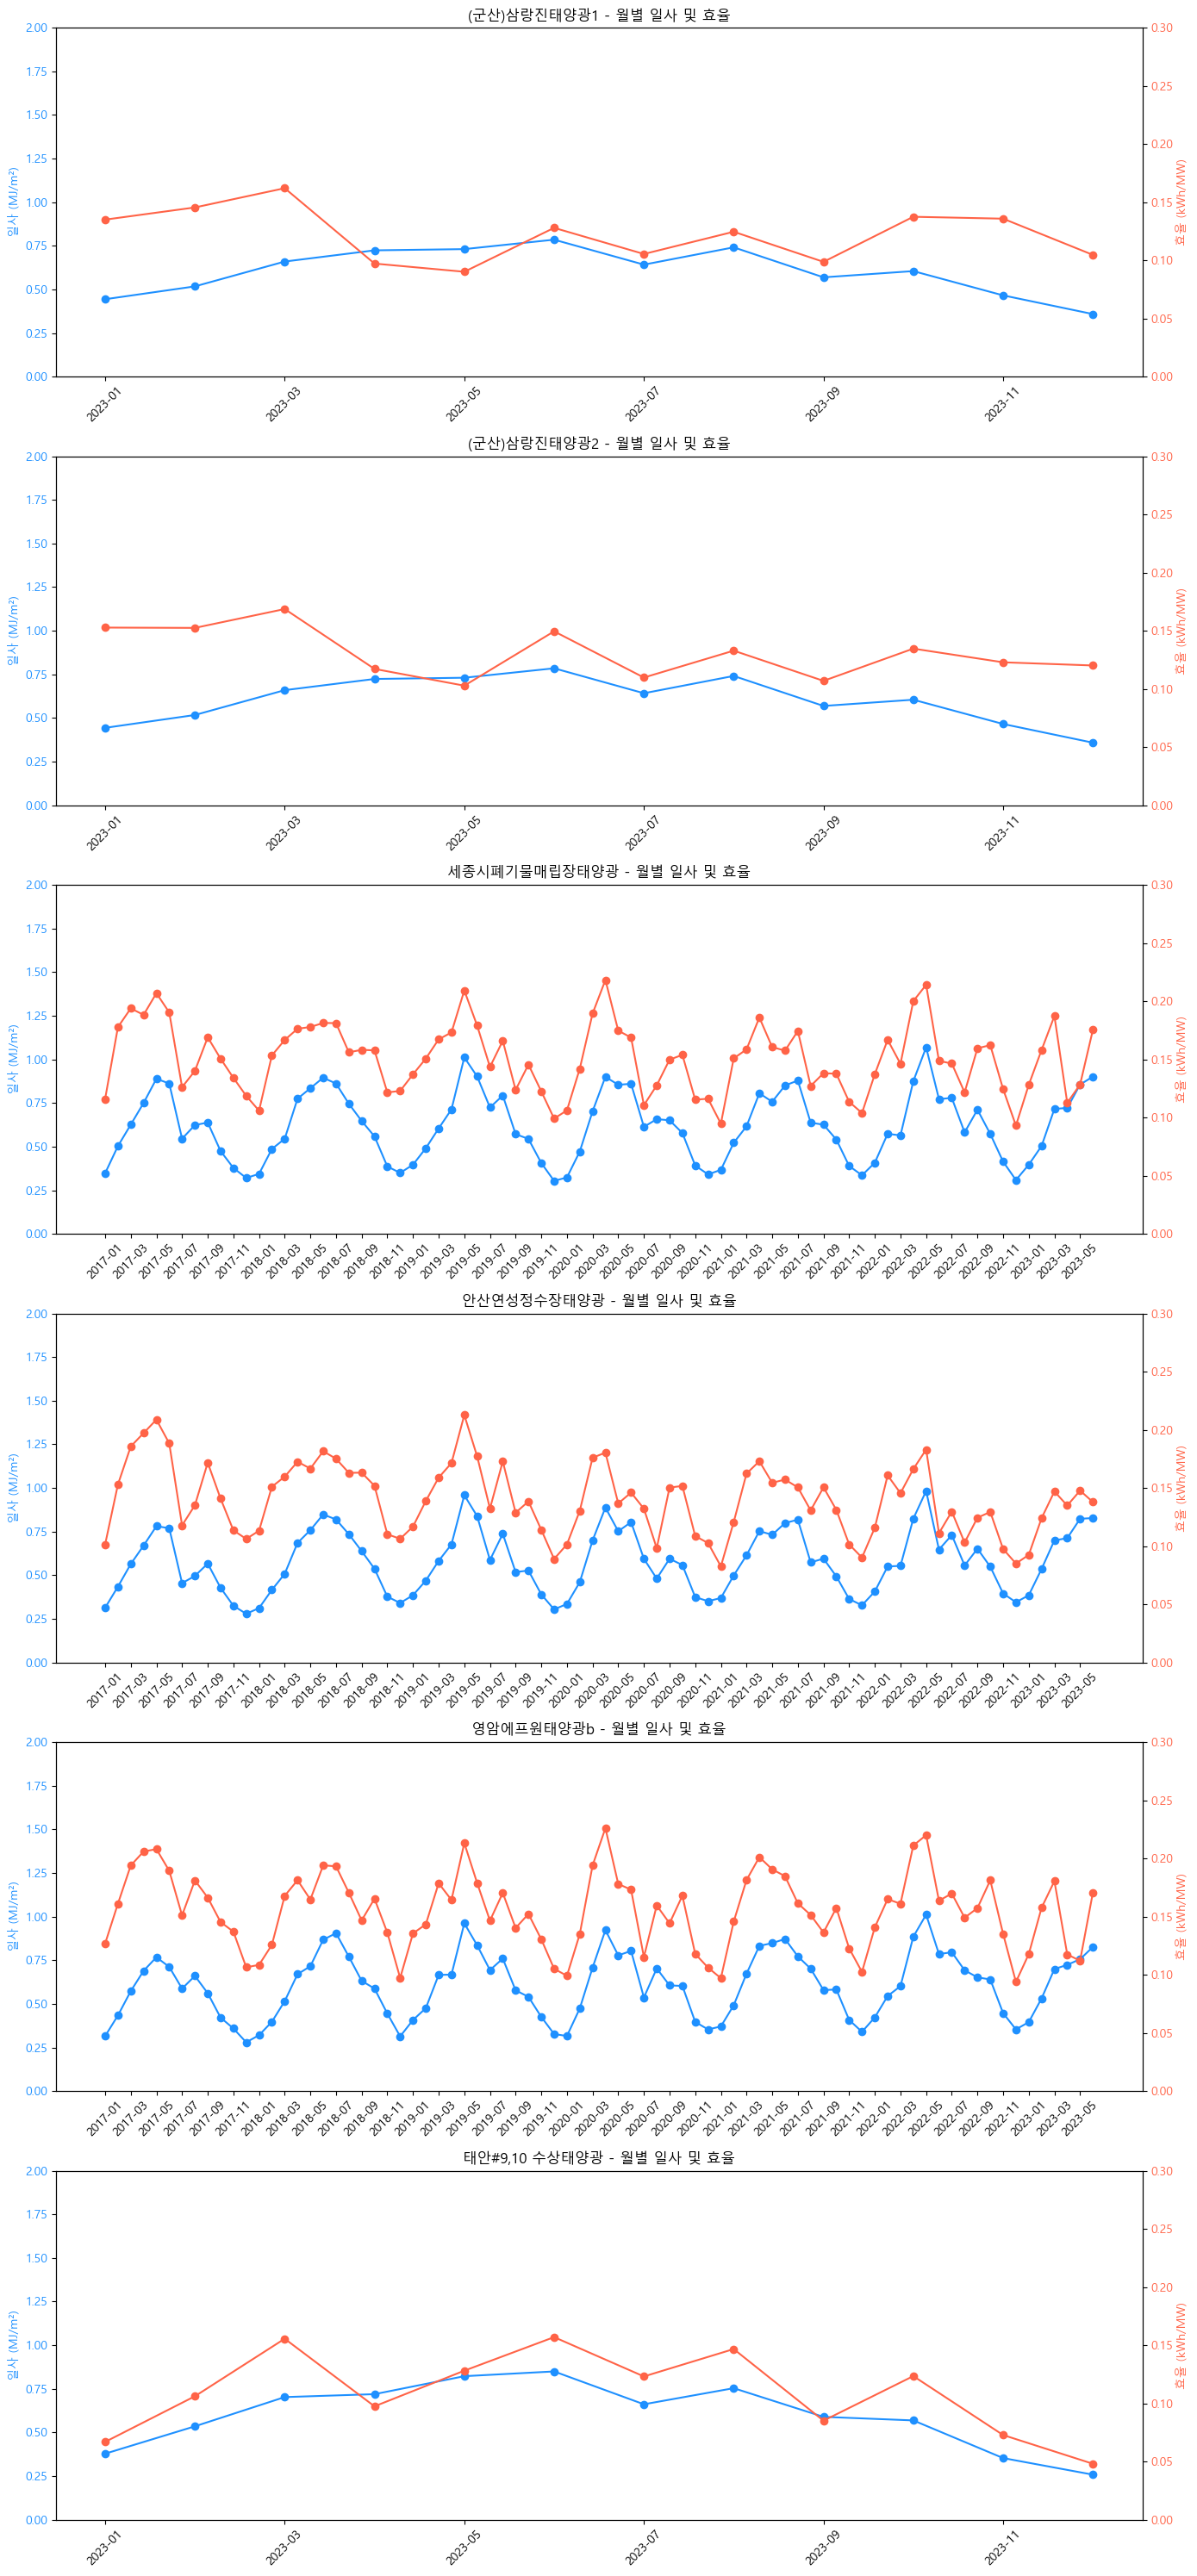

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 사용자 설정 y축 범위
irr_min, irr_max = 0, 2   # 일사 (MJ/m²)
eff_min, eff_max = 0, 0.3      # 효율 (kWh/MW)

# ✅ 연월 및 효율 계산
df_updated['일자'] = pd.to_datetime(df_updated['일자'], errors='coerce')
df_updated['연월'] = df_updated['일자'].dt.to_period('M').astype(str)
df_updated['효율'] = df_updated['발전량(kWh)'] / (df_updated['설비용량(MW)'] * 1000)

# ✅ 결측 제거 및 월별 평균
df_cleaned = df_updated.dropna(subset=['연월', '발전구분', '일사(MJ/m2)', '효율'])
grouped = df_cleaned.groupby(['발전구분', '연월']).agg({
    '일사(MJ/m2)': 'mean',
    '효율': 'mean'
}).reset_index()

# ✅ 발전소 리스트
plants = grouped['발전구분'].unique()
num_plants = len(plants)

# ✅ 전체 Figure 생성 (세로로 나열)
fig, axes = plt.subplots(num_plants, 1, figsize=(14, 5 * num_plants))

if num_plants == 1:
    axes = [axes]  # subplot이 1개일 경우도 리스트로 처리

for i, plant in enumerate(plants):
    ax1 = axes[i]
    sub = grouped[grouped['발전구분'] == plant]
    x = sub['연월']

    # 일사 (왼쪽 y축)
    ax1.plot(x, sub['일사(MJ/m2)'], color='dodgerblue', marker='o', label='일사 (MJ/m²)')
    ax1.set_ylabel('일사 (MJ/m²)', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    ax1.set_ylim(irr_min, irr_max)

    # 효율 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.plot(x, sub['효율'], color='tomato', marker='o', label='효율')
    ax2.set_ylabel('효율 (kWh/MW)', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.set_ylim(eff_min, eff_max)

    # x축 설정
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(x[::2], rotation=45)

    ax1.set_title(f'{plant} - 월별 일사 및 효율')

# ✅ 전체 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('solar3_일사량-발전효율.png', dpi=300)
plt.show()

df_merged = df_updated.drop(columns=['효율', '연월'], errors='ignore')